<a href="https://colab.research.google.com/github/RodrigoArendFlores/Elogroup_Bootcamp-_Analytics_2021/blob/main/ELO_DESAFIO_FINAL_ALTERADO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Digital Bootcamp EloGroup**
# **Case Analytics - Grupo 6**

## **1 Contextualizando o problema**

### **1.1 Objetivo**
Apresentar uma **análise exploratória dos dados**, expondo os insights relevantes e inovadores. O grupo também deverá apresentar um **direcionamento simples e objetivo de possível solução** para uma necessidade real dado os insights encontrados.

### **1.2 Pontos esperados**
- Apresentar as características do conjunto de dados fornecidos, destacando sua **visão geral acerca do conjunto de dados** e tecendo críticas e comentários.
- Apresentar uma **análise detalhada das variáveis** numéricas e categóricas da base dados, discutindo sua **distribuição e outras características relevantes**.
- Apresentar e discutir eventuais **relações entre as variáveis**, tais como dependência, correlação, informação mútua, associações, etc.
- Considerar a avaliação da existência de **valores ausentes e possíveis outliers**, discutindo como estes podem ser tratados ou eliminados.

## **2 Instalando e importando as bibliotecas**

In [ ]:
pip install geopandas

In [ ]:
pip install plotly --upgrade

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import plotly.express as px
import json
from urllib.request import urlopen
import plotly as py
import geopandas as gpd


In [ ]:
import statsmodels.tsa.seasonal
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **3 Importando os dados**

Dados das secretarias estaduais de saúde sobre casos de coronavírus, por município, por dia.

Disponível em: https://brasil.io/dataset/covid19/caso/

In [ ]:
# Baixando a base de dados do Google Drive
!gdown --id 1yljDTEsQZ5Eje7KhvRZFaRAmM4i27ljL

Downloading...
From: https://drive.google.com/uc?id=1yljDTEsQZ5Eje7KhvRZFaRAmM4i27ljL
To: /content/caso_full.csv
100% 281M/281M [00:01<00:00, 179MB/s]


In [ ]:
# Lendo a base de dados 
df = pd.read_csv('caso_full.csv')

In [ ]:
# Conferindo a extração de dados
display(df)

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,Rio Branco,1200401.0,2020-03-17,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-17,0.0000,0,1,city,AC,3,0
1,NaN,12.0,2020-03-17,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-17,0.0000,0,1,state,AC,3,0
2,Rio Branco,1200401.0,2020-03-18,202012,413418.0,407319.0,False,False,3,0.72566,2020-03-18,0.0000,0,2,city,AC,0,0
3,NaN,12.0,2020-03-18,202012,894470.0,881935.0,False,False,3,0.33539,2020-03-18,0.0000,0,2,state,AC,0,0
4,Rio Branco,1200401.0,2020-03-19,202012,413418.0,407319.0,False,False,4,0.96754,2020-03-19,0.0000,0,3,city,AC,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2488955,Tupirama,1721257.0,2021-07-27,202130,1922.0,1891.0,False,True,205,10665.97294,2021-07-20,0.0098,2,431,city,TO,0,0
2488956,Tupiratins,1721307.0,2021-07-27,202130,2729.0,2671.0,False,True,175,6412.60535,2021-07-20,0.0171,3,431,city,TO,0,0
2488957,Wanderlândia,1722081.0,2021-07-27,202130,11734.0,11683.0,False,True,972,8283.62025,2021-07-20,0.0165,16,456,city,TO,0,0
2488958,Xambioá,1722107.0,2021-07-27,202130,11520.0,11540.0,False,True,2342,20329.86111,2021-07-20,0.0137,32,445,city,TO,0,0


## **4 Identificando as variáveis**

Verificando a documentação dos dados.

Disponível em: https://github.com/turicas/covid19-br/blob/master/api.md#casos

0. **city:** nome do município (pode estar em branco quando o registro é referente ao estado, pode ser preenchido com Importados/Indefinidos também). *Existem dados com valores nulos (NaN). Ex: 'Rio Branco'.*
1. **city_ibge_code:** código IBGE do local. *Existem dados com valores nulos(NaN). Ex: '12.0'.*
2. **date:** data de coleta dos dados no formato YYYY-MM-DD. *Ex: '2020-03-17'.*
3. **epidemiological_week:** número da semana epidemiológica no formato YYYYWW. *Ex: '202013' -> décima terceira semana do ano de 2020.*
4. **estimated_population:** população estimada para esse município/estado em 2020, segundo o IBGE. (acesse o script que faz o download e conversão dos dados de população). *Existem dados com valores nulos (NaN). Ex: '413418,0'.*
5. **estimated_population_2019:** população estimada para esse município/estado em 2019, segundo o IBGE. ATENÇÃO: essa coluna possui valores desatualizados, prefira usar a coluna estimated_population. *Existem dados com valores nulos (NaN). Ex: '407319.0'.*
6. **is_last:** campo pré-computado que diz se esse registro é o mais novo para esse local, pode ser True ou False (caso filtre por esse campo, use is_last=True ou is_last=False, não use o valor em minúsculas). *Ex: 'True'/'False'.*
7. **is_repeated:** campo pré-computado que diz se as informações nesse registro foram publicadas pela Secretaria Estadual de Saúde no dia date ou se o dado é repetido do último dia em que o dado está disponível (igual ou anterior a date). Isso ocorre pois nem todas as secretarias publicam boletins todos os dias. Veja também o campo last_available_date. *Ex: 'True'/'False'.*
8. **last_available_confirmed:** número de casos confirmados do último dia disponível igual ou anterior à data date. *Ex: '1'.*
9. **last_available_confirmed_per_100k_inhabitants:** número de casos confirmados por 100.000 habitantes (baseado em estimated_population) do último dia disponível igual ou anterior à data date. *Ex: '1'.*
10. **last_available_date:** data da qual o dado se refere. *Ex:'2020-03-17'.*
11. **last_available_death_rate:** taxa de mortalidade (mortes / confirmados) do último dia disponível igual ou anterior à data date. *Ex: 0,045.*
12. **last_available_deaths:** número de mortes do último dia disponível igual ou anterior à data date. *Ex: '1'.*
13. **order_for_place:** número que identifica a ordem do registro para este local. O registro referente ao primeiro boletim em que esse local aparecer será contabilizado como 1 e os demais boletins incrementarão esse valor. *Ex: '2'.*
14. **place_type:** tipo de local que esse registro descreve, pode ser city ou state. *Ex: 'city'/'state'.*
15. **state:** sigla da unidade federativa. *Ex: SP.*
16. **new_confirmed:** número de novos casos confirmados desde o último dia (note que caso is_repeated seja True, esse valor sempre será 0 e que esse valor pode ser negativo caso a SES remaneje os casos desse município para outro). *Ex: '1'.*
17. **new_deaths:** número de novos óbitos desde o último dia (note que caso is_repeated seja True, esse valor sempre será 0 e que esse valor pode ser negativo caso a SES remaneje os casos desse município para outro). *Ex: '1'.*

## **5 Validando os tipos de variáveis**

In [ ]:
# Identificando os tipos originais
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2488960 entries, 0 to 2488959
Data columns (total 18 columns):
 #   Column                                         Dtype  
---  ------                                         -----  
 0   city                                           object 
 1   city_ibge_code                                 float64
 2   date                                           object 
 3   epidemiological_week                           int64  
 4   estimated_population                           float64
 5   estimated_population_2019                      float64
 6   is_last                                        bool   
 7   is_repeated                                    bool   
 8   last_available_confirmed                       int64  
 9   last_available_confirmed_per_100k_inhabitants  float64
 10  last_available_date                            object 
 11  last_available_death_rate                      float64
 12  last_available_deaths                     

In [ ]:
# Agrupando as variáveis cujo tipo precisa ser alterado
categorical = ['city_ibge_code', 'epidemiological_week']
numerical = ['estimated_population', 'estimated_population_2019']
date = ['date','last_available_date']

In [ ]:
# Alterando o tipo para 'object'
for col in categorical:
  df[col] = df[col].astype('object')

# Alterando o tipo para 'datetime64[ns]'
for col in date:
    df[col] = pd.to_datetime(df[col])

# O tipo das variáveis númericas só pôde ser alterado após a eliminação dos valores nulos (seção 8)

In [ ]:
# Verificando os tipos alterados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2488960 entries, 0 to 2488959
Data columns (total 18 columns):
 #   Column                                         Dtype         
---  ------                                         -----         
 0   city                                           object        
 1   city_ibge_code                                 object        
 2   date                                           datetime64[ns]
 3   epidemiological_week                           object        
 4   estimated_population                           float64       
 5   estimated_population_2019                      float64       
 6   is_last                                        bool          
 7   is_repeated                                    bool          
 8   last_available_confirmed                       int64         
 9   last_available_confirmed_per_100k_inhabitants  float64       
 10  last_available_date                            datetime64[ns]
 11  last_availa

## **6 Verificando a consistência internado dados**

### **6.1 Analisando os valores nulos**

#### **6.1.1 Identificando os valores nulos**

In [ ]:
# Contando os valores nulos por colunas
df.isnull().sum()

city                                             13558
city_ibge_code                                    9029
date                                                 0
epidemiological_week                                 0
estimated_population                              9029
estimated_population_2019                         9029
is_last                                              0
is_repeated                                          0
last_available_confirmed                             0
last_available_confirmed_per_100k_inhabitants    24549
last_available_date                                  0
last_available_death_rate                            0
last_available_deaths                                0
order_for_place                                      0
place_type                                           0
state                                                0
new_confirmed                                        0
new_deaths                                           0
dtype: int

In [ ]:
# Verificando a porcentagem de valores nulos por coluna
df.isnull().sum() * 100 / len(df)

city                                             0.544726
city_ibge_code                                   0.362762
date                                             0.000000
epidemiological_week                             0.000000
estimated_population                             0.362762
estimated_population_2019                        0.362762
is_last                                          0.000000
is_repeated                                      0.000000
last_available_confirmed                         0.000000
last_available_confirmed_per_100k_inhabitants    0.986316
last_available_date                              0.000000
last_available_death_rate                        0.000000
last_available_deaths                            0.000000
order_for_place                                  0.000000
place_type                                       0.000000
state                                            0.000000
new_confirmed                                    0.000000
new_deaths    

**Conclusão:** O dataframe possui valores nulos nas colunas 'city', 'city_ibge_code', 'estimated_population', 'estimated_population_2019' e 'last_available_confirmed_per_100k_inhabitants'. Embora a quantidade de valores nulos não seja significativa quando consideramos o conjunto dos dados, decidimos investigar suas causas e entender como afetam os resultados.

#### **6.1.2 Analisando os valores nulos por coluna**

##### **6.1.2.2 Analisando a coluna 'city'**

**Hipótese:** Os valores nulos ocorrem nas linhas cujo 'place_type' é 'state'.

In [ ]:
# Agrupando o dataframe por categorias de 'place_type'
df.groupby(['place_type']).count()

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,state,new_confirmed,new_deaths
place_type,,,,,,,,,,,,,,,,,
city,2475402,2466373,2475402,2475402,2466373,2466373,2475402,2475402,2475402,2450859,2475402,2475402,2475402,2475402,2475402,2475402,2475402
state,0,13558,13558,13558,13558,13558,13558,13558,13558,13552,13558,13558,13558,13558,13558,13558,13558


**Conclusão:** Hipótese confirmada.

In [ ]:
# Contando os valores nulos dos dados municipais ('place_type' = 'city')
df_city = df[df['place_type']=='city']
df_city.isnull().sum()

city                                                 0
city_ibge_code                                    9029
date                                                 0
epidemiological_week                                 0
estimated_population                              9029
estimated_population_2019                         9029
is_last                                              0
is_repeated                                          0
last_available_confirmed                             0
last_available_confirmed_per_100k_inhabitants    24543
last_available_date                                  0
last_available_death_rate                            0
last_available_deaths                                0
order_for_place                                      0
place_type                                           0
state                                                0
new_confirmed                                        0
new_deaths                                           0
dtype: int

In [ ]:
# Contando os valores nulos dos dados estaduais ('place_type' = 'state')
df_state = df[df['place_type']=='state']
df_state.isnull().sum()

city                                             13558
city_ibge_code                                       0
date                                                 0
epidemiological_week                                 0
estimated_population                                 0
estimated_population_2019                            0
is_last                                              0
is_repeated                                          0
last_available_confirmed                             0
last_available_confirmed_per_100k_inhabitants        6
last_available_date                                  0
last_available_death_rate                            0
last_available_deaths                                0
order_for_place                                      0
place_type                                           0
state                                                0
new_confirmed                                        0
new_deaths                                           0
dtype: int

**Conclusão:** Nas linhas com valores nulos na coluna 'city', os demais campos estão preenchidos, exceto 6 linhas com valores nulos na coluna 'last_available_confirmed_per_100k_inhabitants'.

**Conclusão geral:** As 13558 linhas com valor nulo na coluna 'city' correspondem a dados agregados estaduais ('place_type' = 'state'). Em 6 dessas ocorrências, houve algum erro no cálculo da variável 'last_available_confirmed_per_100k_inhabitants'.

##### **6.1.2.2 Analisando as colunas 'city_ibge_code', 'estimated_population' e 'estimated_population_2019'**

**Hipótese:** As linhas com valores nulos em 'city_ibge_code' correspondem a linhas com valores nulos em 'estimated_population' e 'estimated_population_2019'.

In [ ]:
# Contando os valores nulos quando a variável 'city_ibge_code' é nula
df[df['city_ibge_code'].isnull()].isnull().sum()

city                                                0
city_ibge_code                                   9029
date                                                0
epidemiological_week                                0
estimated_population                             9029
estimated_population_2019                        9029
is_last                                             0
is_repeated                                         0
last_available_confirmed                            0
last_available_confirmed_per_100k_inhabitants    9029
last_available_date                                 0
last_available_death_rate                           0
last_available_deaths                               0
order_for_place                                     0
place_type                                          0
state                                               0
new_confirmed                                       0
new_deaths                                          0
dtype: int64

**Conclusão:** Hipótese confirmada. Além disso, essas linhas apresentam valores nulos em 'last_available_confirmed_per_100k_inhabitants'.

In [ ]:
# Visualizando os dados quando a variável 'city_ibge_code' é nula
display(df[df['city_ibge_code'].isnull()])

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
10607,Importados/Indefinidos,NaN,2020-03-29,202014,NaN,NaN,False,False,4,NaN,2020-03-29,0.0,0,1,city,AL,4,0
10611,Importados/Indefinidos,NaN,2020-03-30,202014,NaN,NaN,False,False,4,NaN,2020-03-30,0.0,0,2,city,AL,0,0
10615,Importados/Indefinidos,NaN,2020-03-31,202014,NaN,NaN,False,False,4,NaN,2020-03-31,0.0,0,3,city,AL,0,0
10619,Importados/Indefinidos,NaN,2020-04-01,202014,NaN,NaN,False,False,4,NaN,2020-04-01,0.0,0,4,city,AL,0,0
10623,Importados/Indefinidos,NaN,2020-04-02,202014,NaN,NaN,False,False,4,NaN,2020-04-02,0.0,0,5,city,AL,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424205,Importados/Indefinidos,NaN,2021-07-23,202129,NaN,NaN,False,False,972,NaN,2021-07-23,0.0,0,492,city,SP,2,0
2424852,Importados/Indefinidos,NaN,2021-07-24,202129,NaN,NaN,False,True,972,NaN,2021-07-23,0.0,0,493,city,SP,0,0
2425499,Importados/Indefinidos,NaN,2021-07-25,202130,NaN,NaN,True,False,972,NaN,2021-07-25,0.0,0,494,city,SP,0,0
2426146,Importados/Indefinidos,NaN,2021-07-26,202130,NaN,NaN,False,True,972,NaN,2021-07-25,0.0,0,495,city,SP,0,0


**Hipótese:** Linhas com valores nulos na coluna 'city_ibge_code' correspondem a linhas com 'Importados/Indefinidos' na coluna 'city'.

In [ ]:
# Contando os valores nulos quando 'city' = 'Importados/Indefinidos'
df[df['city']=='Importados/Indefinidos'].isnull().sum()

city                                                0
city_ibge_code                                   9029
date                                                0
epidemiological_week                                0
estimated_population                             9029
estimated_population_2019                        9029
is_last                                             0
is_repeated                                         0
last_available_confirmed                            0
last_available_confirmed_per_100k_inhabitants    9029
last_available_date                                 0
last_available_death_rate                           0
last_available_deaths                               0
order_for_place                                     0
place_type                                          0
state                                               0
new_confirmed                                       0
new_deaths                                          0
dtype: int64

**Conclusão:** Hipótese confirmada.

In [ ]:
# Verificando se os erros tem origem em uma localidade específica
df[df['city_ibge_code'].isnull()].groupby('state').count()

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,new_confirmed,new_deaths
state,,,,,,,,,,,,,,,,,
AL,486,0,486,486,0,0,486,486,486,0,486,486,486,486,486,486,486
BA,491,0,491,491,0,0,491,491,491,0,491,491,491,491,491,491,491
CE,496,0,496,496,0,0,496,496,496,0,496,496,496,496,496,496,496
DF,489,0,489,489,0,0,489,489,489,0,489,489,489,489,489,489,489
ES,491,0,491,491,0,0,491,491,491,0,491,491,491,491,491,491,491
GO,496,0,496,496,0,0,496,496,496,0,496,496,496,496,496,496,496
MG,494,0,494,494,0,0,494,494,494,0,494,494,494,494,494,494,494
MT,478,0,478,478,0,0,478,478,478,0,478,478,478,478,478,478,478
PA,464,0,464,464,0,0,464,464,464,0,464,464,464,464,464,464,464


**Conclusão:** Os erros estão bem distribuídos entre 19 estados, e não afetam significativamente as estatísticas.

**Conclusão geral:** Em 9029 registros municipais, a base não informa qual é o nome do município ('city' = 'Importados/Indefinidos'), tampouco o seu código IBGE e a sua população estimada. Além disso, essas linhas apresentam valores nulos em 'last_available_confirmed_per_100k_inhabitants'.

##### **6.1.2.3 Analisando a coluna 'last_available_confirmed_per_100k_inhabitants'**

**Hipótese 1 (parcial):** Nas 9029 linhas analisadas na seção 6.2.2, o cálculo de 'last_available_confirmed_per_100k_inhabitants' é comprometido pela indisponibilidade de dados sobre o tamanho da população.

In [ ]:
# Visualizando os dados quando a variável 'last_available_confirmed_per_100k_inhabitants' é nula
df[df['last_available_confirmed_per_100k_inhabitants'].isnull()]

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
431,Manoel Urbano,1.20034e+06,2020-05-13,202020,9581.0,9459.0,False,False,0,NaN,2020-05-13,0.0,0,1,city,AC,0,0
436,Porto Walter,1.20039e+06,2020-05-13,202020,12241.0,11982.0,False,False,0,NaN,2020-05-13,0.0,0,1,city,AC,0,0
453,Manoel Urbano,1.20034e+06,2020-05-14,202020,9581.0,9459.0,False,False,0,NaN,2020-05-14,0.0,0,2,city,AC,0,0
458,Porto Walter,1.20039e+06,2020-05-14,202020,12241.0,11982.0,False,False,0,NaN,2020-05-14,0.0,0,2,city,AC,0,0
475,Manoel Urbano,1.20034e+06,2020-05-15,202020,9581.0,9459.0,False,False,0,NaN,2020-05-15,0.0,0,3,city,AC,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437792,Mateiros,1.7127e+06,2020-07-27,202031,2729.0,2684.0,False,False,0,NaN,2020-07-27,0.0,0,66,city,TO,0,0
2437932,Mateiros,1.7127e+06,2020-07-28,202031,2729.0,2684.0,False,False,0,NaN,2020-07-28,0.0,0,67,city,TO,0,0
2438072,Mateiros,1.7127e+06,2020-07-29,202031,2729.0,2684.0,False,False,0,NaN,2020-07-29,0.0,0,68,city,TO,0,0
2438212,Mateiros,1.7127e+06,2020-07-30,202031,2729.0,2684.0,False,False,0,NaN,2020-07-30,0.0,0,69,city,TO,0,0


**Hipótese 2:** Os valores nulos correspondem a um erro de cálculo quando a variável 'last_available_confirmed' é zero.

In [ ]:
# Contando os valores nulos quando a variável 'last_available_confirmed' é zero
df[df['last_available_confirmed']==0].isnull().sum()

city                                                 6
city_ibge_code                                    3231
date                                                 0
epidemiological_week                                 0
estimated_population                              3231
estimated_population_2019                         3231
is_last                                              0
is_repeated                                          0
last_available_confirmed                             0
last_available_confirmed_per_100k_inhabitants    18751
last_available_date                                  0
last_available_death_rate                            0
last_available_deaths                                0
order_for_place                                      0
place_type                                           0
state                                                0
new_confirmed                                        0
new_deaths                                           0
dtype: int

In [ ]:
# Contando os valores nulos quando a variável 'last_available_confirmed' não é zero
df[df['last_available_confirmed']!=0].isnull().sum()

city                                             13552
city_ibge_code                                    5798
date                                                 0
epidemiological_week                                 0
estimated_population                              5798
estimated_population_2019                         5798
is_last                                              0
is_repeated                                          0
last_available_confirmed                             0
last_available_confirmed_per_100k_inhabitants     5798
last_available_date                                  0
last_available_death_rate                            0
last_available_deaths                                0
order_for_place                                      0
place_type                                           0
state                                                0
new_confirmed                                        0
new_deaths                                           0
dtype: int

In [ ]:
# Contando os valores nulos quando 'last_available_confirmed' é zero e 'estimated_population' é nula
df[(df['last_available_confirmed']==0) & (df['estimated_population'].isnull())].isnull().sum()

city                                                0
city_ibge_code                                   3231
date                                                0
epidemiological_week                                0
estimated_population                             3231
estimated_population_2019                        3231
is_last                                             0
is_repeated                                         0
last_available_confirmed                            0
last_available_confirmed_per_100k_inhabitants    3231
last_available_date                                 0
last_available_death_rate                           0
last_available_deaths                               0
order_for_place                                     0
place_type                                          0
state                                               0
new_confirmed                                       0
new_deaths                                          0
dtype: int64

**Conclusão:** Hipóteses 1 e 2 confirmadas.

**Conclusão geral:** A coluna 'last_available_confirmed_per_100k_inhabitants' apresenta valores nulos quando a variável 'estimated_population' é nula (o município não pode ser identificado) e/ou quando a variável 'last_available_confirmed' é zero (nenhum caso identificado). Como esse dado se trata de uma razão entre essas variáveis (ver seção 4), é razoável que haja algum erro no cálculo. Contudo, acreditamos que o valor deve ser zero quando ainda não foram registrados casos, mas o município pode ser identificado.

### **6.2 Sanity Check**

#### **6.2.1 Entre dados estaduais e municipais**

##### **6.2.1.1 Casos e mortes**

In [ ]:
# Verificando a diferença entre os casos e mortes estaduais e a soma dos casos e mortes municipais
sum_data_state = df_state.groupby('state')[['new_confirmed','new_deaths']].sum()
sum_data_city = df_city.groupby('state')[['new_confirmed','new_deaths']].sum()
sum_data_state - sum_data_city

,new_confirmed,new_deaths
state,,
AC,47,1
AL,10795,380
AM,445,9
AP,78,1
BA,6818,184
CE,3511,63
DF,582,11
ES,689,19
GO,3520,17


**Conclusão:** Há pequenas inconsistências. Os estados que apresentam as maiores diferenças são MG e SP.

##### **6.2.1.2 População**

In [ ]:
# Verificando a diferença entre a população estadual e a soma das populações municipais
max_pop_state = df_state.groupby('state')[['estimated_population']].max()
max_pop_city = df_city.groupby('city')[['estimated_population','state']].max()
sum_pop_city = max_pop_city.groupby('state').sum()
max_pop_state - sum_pop_city

,estimated_population
state,
AC,502490.0
AL,339723.0
AM,134807.0
AP,123096.0
BA,831252.0
CE,606550.0
DF,0.0
ES,136029.0
GO,208150.0


**Conclusão:** Há algumas inconsistências. Os estados que apresentam as maiores diferenças são PA, PB e RN.

**Conclusão geral:** Os dados estaduais extrapolam a soma dos dados municipais correspondentes. Uma possível causa para esse problema seria a inclusão de municípios não listados no dataframe. Contudo, acreditamos que isso seja improvável, pois ambos os dados são publicados pelas secretarias estaduais de saúde.

#### **6.2.2 Entre as colunas 'city_ibge_code' e 'state'**

In [ ]:
# Cruzamento dos dados das duas colunas
pd.crosstab(df_state['city_ibge_code'], df_state['state'])

state,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
city_ibge_code,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,495,0,0,0,0,0,0
12.0,498,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13.0,0,0,502,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,494,0,0,0,0,0
15.0,0,0,0,0,0,0,0,0,0,0,0,0,0,497,0,0,0,0,0,0,0,0,0,0,0,0,0
16.0,0,0,0,495,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,497
21.0,0,0,0,0,0,0,0,0,0,495,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,496,0,0,0,0,0,0,0,0,0,0


**Conclusão:** Os dados são consistentes e redundantes. O estado pode ser identificado tanto pela coluna 'city_ibge_code' quanto pela coluna 'state'.

#### **6.2.3 Entre as colunas 'last_available_deaths' e 'new_deaths'**

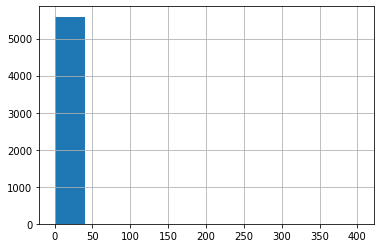

In [ ]:
# Verificando a diferença entre a soma das novas mortes por dia
# e o valor máximo do total de mortes até o dia

max_deaths = df['last_available_deaths'].groupby(df['city_ibge_code']).max()
sum_new_deaths = df['new_deaths'].groupby(df['city_ibge_code']).sum()
(max_deaths - sum_new_deaths).hist()

city_ibge_code
2101731.0     14
2105807.0     17
2105922.0     59
2105948.0     53
2110237.0     14
2111201.0     20
4316758.0    149
4316956.0     98
4316972.0    402
4317004.0     67
4317251.0     17
dtype: int64

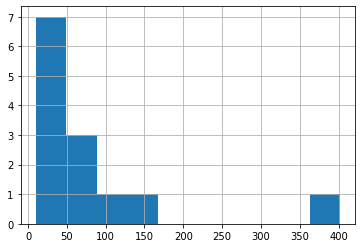

In [ ]:
(max_deaths - sum_new_deaths).hist(range = [10, max(max_deaths - sum_new_deaths)])
(max_deaths - sum_new_deaths)[(max_deaths - sum_new_deaths)>10]

**Conclusão:** Há pequenas inconsistências. Os estados que apresentam as maiores diferenças são MA e RS.

#### **6.2.4 Entre as colunas 'last_available_confirmed' e 'new_confirmed'**

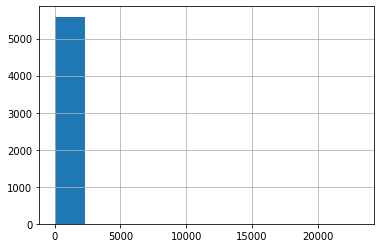

In [ ]:
# Verificando a diferença entre a soma dos novos casos por dia
# e o valor máximo do total de casos até o dia

max_confirmed = df['last_available_confirmed'].groupby(df['city_ibge_code']).max()
sum_confirmed = df['new_confirmed'].groupby(df['city_ibge_code']).sum()
(max_confirmed - sum_confirmed).hist()

city_ibge_code
1100122.0     1418
2101772.0      189
2105948.0     2143
2105963.0      515
2110237.0      572
2401404.0      940
2401602.0      122
2402402.0     1767
2402709.0     2986
2402808.0      200
2403004.0      226
2403202.0     3122
2403400.0      276
2403707.0     2432
2403756.0      775
2403905.0      909
2404101.0      656
2404309.0     1473
2404606.0     1553
2404804.0     1073
2404903.0      186
2405207.0      329
2504702.0      149
3107406.0     1165
3125101.0      163
3143906.0      322
3147006.0      755
3155009.0      186
3165909.0      169
4100400.0      146
4101507.0      477
4101804.0      103
4102802.0      120
4103701.0      414
4104204.0      121
4104808.0      419
4105805.0      402
4107652.0      454
4108304.0      530
4108809.0      111
4109401.0      167
4113700.0      610
4115200.0      447
4115804.0      107
4117206.0      310
4118204.0      667
4119152.0      275
4119509.0      289
4119905.0      469
4122404.0      106
4316758.0    11338
4316956.0     88

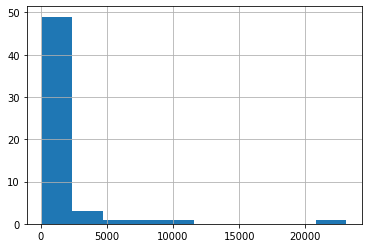

In [ ]:
(max_confirmed - sum_confirmed).hist(range = [100, max(max_confirmed - sum_confirmed)])
(max_confirmed - sum_confirmed)[(max_confirmed - sum_confirmed)>100]

**Conclusão:** Há pequenas inconsistências. Os estados que apresentam as maiores diferenças são RN e PR.

## **7 Preparando os dados para gerar visualizações**

Optamos por trabalhar com duas bases de dados segmentadas: uma de dados municipais e outra de dados estaduais.

### **7.1 Tratando os valores nulos**

#### **7.1.1 Base de dados municipais**

In [ ]:
# Duplicando a base de dados municipais (ver seção 6.2.1)
df_filtered_city = df_city

# Desconsiderando os registros nos quais o município não é identificado (ver seção 6.2.2)
df_filtered_city = df_filtered_city[df_filtered_city['city']!='Importados/Indefinidos']

# Substituindo os valores nulos quando 'last_available_confirmed' é zero (ver seção 6.2.3)
df_filtered_city = df_filtered_city.fillna({'last_available_confirmed_per_100k_inhabitants':0})

# Contando os valores nulos da base filtrada
df_filtered_city.isnull().sum()

city                                             0
city_ibge_code                                   0
date                                             0
epidemiological_week                             0
estimated_population                             0
estimated_population_2019                        0
is_last                                          0
is_repeated                                      0
last_available_confirmed                         0
last_available_confirmed_per_100k_inhabitants    0
last_available_date                              0
last_available_death_rate                        0
last_available_deaths                            0
order_for_place                                  0
place_type                                       0
state                                            0
new_confirmed                                    0
new_deaths                                       0
dtype: int64

#### **7.1.2 Base de dados estaduais**

In [ ]:
# Duplicando a base de dados estaduais (ver seção 6.2.1)
df_filtered_state = df_state

# Retirando a coluna 'city' (ver seção 6.2.1)
df_filtered_state = df_filtered_state.drop(columns=['city'])

# Substituindo os valores nulos quando 'last_available_confirmed' é zero (ver seção 6.2.3)
df_filtered_state = df_filtered_state.fillna({'last_available_confirmed_per_100k_inhabitants':0})

# Contando os valores nulos da base filtrada
df_filtered_state.isnull().sum()

city_ibge_code                                   0
date                                             0
epidemiological_week                             0
estimated_population                             0
estimated_population_2019                        0
is_last                                          0
is_repeated                                      0
last_available_confirmed                         0
last_available_confirmed_per_100k_inhabitants    0
last_available_date                              0
last_available_death_rate                        0
last_available_deaths                            0
order_for_place                                  0
place_type                                       0
state                                            0
new_confirmed                                    0
new_deaths                                       0
dtype: int64

### **7.2 Validando os tipos de variáveis**

In [ ]:
# Alterando o tipo para 'int64'
for col in numerical:
    df_filtered_city[col] = df_filtered_city[col].astype('int64')
    df_filtered_state[col] = df_filtered_state[col].astype('int64')

In [ ]:
# Verificando os tipos alterados na base de dados municipais
df_filtered_city.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466373 entries, 0 to 2488958
Data columns (total 18 columns):
 #   Column                                         Dtype         
---  ------                                         -----         
 0   city                                           object        
 1   city_ibge_code                                 object        
 2   date                                           datetime64[ns]
 3   epidemiological_week                           object        
 4   estimated_population                           int64         
 5   estimated_population_2019                      int64         
 6   is_last                                        bool          
 7   is_repeated                                    bool          
 8   last_available_confirmed                       int64         
 9   last_available_confirmed_per_100k_inhabitants  float64       
 10  last_available_date                            datetime64[ns]
 11  last_availa

In [ ]:
# Verificando os tipos alterados na base de dados estaduais
df_filtered_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13558 entries, 1 to 2488959
Data columns (total 17 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   city_ibge_code                                 13558 non-null  object        
 1   date                                           13558 non-null  datetime64[ns]
 2   epidemiological_week                           13558 non-null  object        
 3   estimated_population                           13558 non-null  int64         
 4   estimated_population_2019                      13558 non-null  int64         
 5   is_last                                        13558 non-null  bool          
 6   is_repeated                                    13558 non-null  bool          
 7   last_available_confirmed                       13558 non-null  int64         
 8   last_available_confirmed_per_100k_inhabitants  13558 n

### **7.3 Acrescentando novas variáveis**

Foi necessário criar novas variáveis para aprimorar nossas análises sobre os dados do dataframe. Variáveis criadas: 
- **last_available_deaths_per_100k_inhabitants:** Número de mortes por 100.000 habitantes (baseado em estimated_population) do último dia disponível igual ou anterior à data date
- **new_confirmed_per_100k_inhabitants:** Número de novos casos confirmados desde o último dia por 100.000 habitantes (baseado em estimated_population).
- **new_deaths_per_100k_inhabitants:** Número de novas mortes desde o último dia por 100.000 habitantes (baseado em estimated_population).

In [ ]:
# Acrescentando uma nova variável aos dataframes: last_available_deaths_per_100k_inhabitants
df_filtered_city.insert(13,'last_available_deaths_per_100k_inhabitants', (df_filtered_city['last_available_deaths'] / df_filtered_city['estimated_population'] * 100000), True)
df_filtered_state.insert(12,'last_available_deaths_per_100k_inhabitants', (df_filtered_state['last_available_deaths'] / df_filtered_state['estimated_population'] * 100000), True)

In [ ]:
# Acrescentando uma nova variável aos dataframes: new_confirmed_per_inhabitants
df_filtered_city.insert(18,'new_confirmed_per_100k_inhabitants', (df_filtered_city['new_confirmed'] / df_filtered_city['estimated_population']* 100000), True)
df_filtered_state.insert(17,'new_confirmed_per_100k_inhabitants', (df_filtered_state['new_confirmed'] / df_filtered_state['estimated_population']* 100000), True)

In [ ]:
# Acrescentando uma nova variável aos dataframes: new_deaths_per_inhabitants
df_filtered_city.insert(20,'new_deaths_per_100k_inhabitants', (df_filtered_city['new_deaths'] / df_filtered_city['estimated_population']* 100000), True)
df_filtered_state.insert(19,'new_deaths_per_100k_inhabitants', (df_filtered_state['new_deaths'] / df_filtered_state['estimated_population']* 100000), True)

## **8 Análise exploratória de dados**

Nesta seção, serão utilizados metódos estatísticos e técnicas de visualização para entender melhor os dados e identificar insights sobre tendências e a sua qualidade, bem como para formular hipóteses e fazer suposições nas análises. 



Visto que os dados municipais se comportam de maneira semelhante aos estaduais, foi decidido trabalhar apenas os dados estaduais nas visualizações desse notebook para melhor visualização para o leitor.

### **8.1 Analises numéricas e descritivas**

#### **8.1.1 Compreendendo os dados**

Abaixo estão listadas as variáveis do dataframe que serão analisadas. Junto a elas foram separadas as dimensões dessas variáveis. Elas já foram descritas no tópico 4.

**Variáveis analisadas:**
1. last_available_confirmed
2. last_available_confirmed_per_100k_inhabitants
3. last_available_deaths
4. last_available_deaths_per_100k_inhabitants
5. last_available_death_rate
6. new_confirmed
7. new_deaths
8. new_confirmed_per_100k_inhabitants
9. new_deaths_per_100k_inhabitants


**Varíavel auxiliar:**
1. estimated_population

**Dimensões das variáveis:**
- Data:
1. last_available_date
2. date
- Local:
1. city
2. state

In [ ]:
# Analisando algumas estatístiscas básicas
df_filtered_city.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,estimated_population,estimated_population_2019,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,last_available_deaths_per_100k_inhabitants,order_for_place,new_confirmed,new_confirmed_per_100k_inhabitants,new_deaths,new_deaths_per_100k_inhabitants
count,2466373.00000,2466373.00000,2466373.00000,2466373.00000,2466373.00000,2466373.00000,2466373.00000,2466373.00000,2466373.00000,2466373.00000,2466373.00000,2466373.00000
mean,41105.87677,40790.00522,1499.60477,3593.51172,0.02794,41.44415,72.64932,222.89384,7.85323,20.56955,0.21982,0.44009
std,239334.70589,237798.81419,9889.08038,3787.97923,0.06034,405.31268,82.40280,129.49709,76.76443,852.86418,2.45942,14.79783
min,776.00000,781.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,-23275.00000,-902831.65244,-407.00000,-15787.43212
25%,5651.00000,5644.00000,65.00000,754.48773,0.00840,1.00000,11.80220,111.00000,0.00000,0.00000,0.00000,0.00000
50%,12288.00000,12238.00000,262.00000,2408.77342,0.01850,5.00000,46.86036,222.00000,0.00000,0.00000,0.00000,0.00000
75%,26987.00000,26816.00000,830.00000,5289.28645,0.03050,17.00000,104.22095,333.00000,3.00000,19.90974,0.00000,0.00000
max,12325232.00000,12252023.00000,894918.00000,904809.93018,1.00000,35120.00000,15787.43212,519.00000,40170.00000,902831.65244,589.00000,15787.43212


Com a tabela acima e as descrições da variáveis da documentação (4) podemos entender melhor as variáveis

#### **8.1.2 Vendo as distribuições das séries e verificando outliers**


In [ ]:
# Arrumando o dataframe de novos casos para as análises
df_filtered_new = df_filtered_city[['epidemiological_week','new_confirmed','new_deaths']]
display(df_filtered_new)

,epidemiological_week,new_confirmed,new_deaths
0,202012,3,0
2,202012,0,0
4,202012,1,0
6,202012,3,0
8,202012,4,0
...,...,...,...
2488954,202130,0,0
2488955,202130,0,0
2488956,202130,0,0
2488957,202130,0,0


In [ ]:
# Arrumando data frame de casos acumulados para as análises
df_filtered_acu = df_filtered_city[['epidemiological_week','last_available_confirmed','last_available_deaths']]
display(df_filtered_acu)

,epidemiological_week,last_available_confirmed,last_available_deaths
0,202012,3,0
2,202012,3,0
4,202012,4,0
6,202012,7,0
8,202012,11,0
...,...,...,...
2488954,202130,826,13
2488955,202130,205,2
2488956,202130,175,3
2488957,202130,972,16


##### **8.1.2.1 Histogramas**

###### **8.1.2.1.1 Histogramas das cidades e estados**

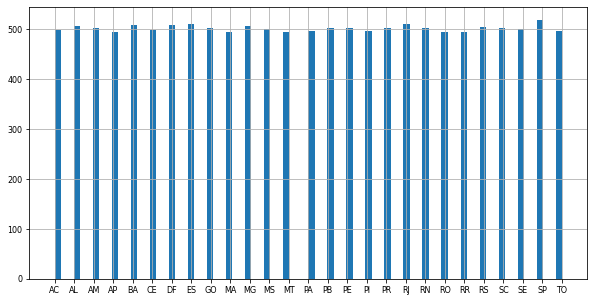

In [ ]:
# Distruibuições dos estados (cidades tiradadas da base) - verificando quais estados(sem as cidades) tem mais dados na base
df_filtered_state['state'].hist(figsize=(10, 5), bins=80, xlabelsize=8, ylabelsize=8)

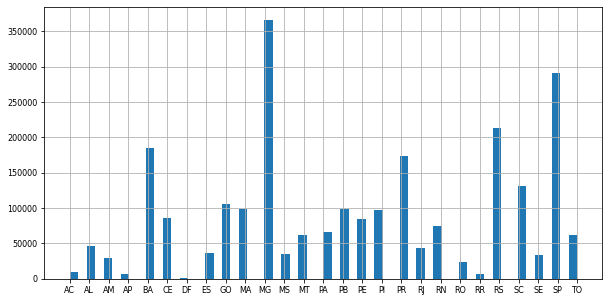

In [ ]:
# Distruibuições dos estados(df cidade) - De qual estado mais aparecem cidades no Df.
df_filtered_city['state'].hist(figsize=(10, 5), bins=60, xlabelsize=8, ylabelsize=8)

In [ ]:
# Distruibuições das cidades - Qual cidade mais aparece mais na base.
df_filtered_city_group = df_filtered_city[['city']].groupby(df_filtered_city['city']).count()
df_filtered_city_group = df_filtered_city_group.rename({'city': 'city_count'}, axis=1) 
df_filtered_city_group = df_filtered_city_group.reset_index()

fig = px.bar(df_filtered_city_group, x='city', y='city_count')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

# O grande número de cidades dificulta a visualização, mas a maioria das ciadades aparece em torno de 500 vezes na base. 

In [ ]:
# Estados com mais casos e mortes.
df_filtered_state_group = df_filtered_state[['state','new_confirmed','new_deaths']].groupby(df_filtered_state['state']).sum().reset_index()
fig = px.bar(df_filtered_state_group, x='state', y='new_confirmed')
fig.show()
fig = px.bar(df_filtered_state_group, x='state', y='new_deaths')
fig.show()
# Confirmados e mortes no total da série seguem o mesmo padrão.

###### **8.1.2.1.2 Histogramas dos casos e mortes**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c4231df10>,
      dtype=object)

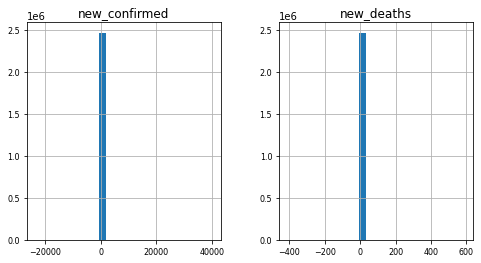

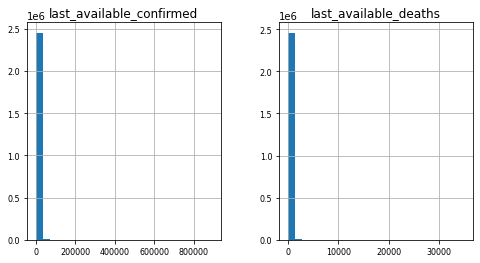

In [ ]:
# Visualizando histogramas dos casos e mortes do período total
df_filtered_new.hist(figsize=(8, 4), bins=25, xlabelsize=8, ylabelsize=8)
df_filtered_acu.hist(figsize=(8, 4), bins=25, xlabelsize=8, ylabelsize=8)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c42011050>,
      dtype=object)

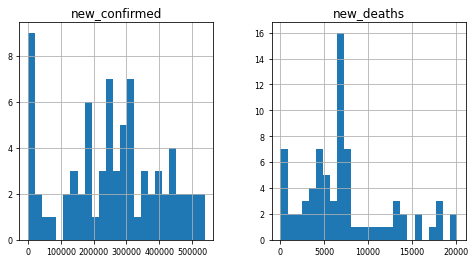

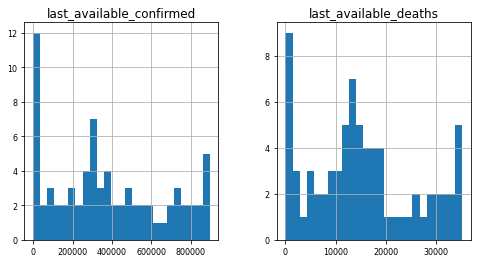

In [ ]:
# Agrupando os casos e mortes por epidemiological_week para melhor visualização dos dados
df_filtered_new.groupby(['epidemiological_week']).sum().hist(figsize=(8, 4), bins=25, xlabelsize=8, ylabelsize=8)
df_filtered_acu.groupby(['epidemiological_week']).max().hist(figsize=(8, 4), bins=25, xlabelsize=8, ylabelsize=8)

In [ ]:
# Visualizando a distribuiação dos CASOS agrupandos por dia
df_state_agrupado_tm_m3 = df_filtered_state.groupby([pd.Grouper(key = 'date', freq='d'),'state'])[['new_confirmed','new_deaths', 'new_confirmed_per_100k_inhabitants','new_deaths_per_100k_inhabitants']].sum().reset_index()
fig = px.bar(df_state_agrupado_tm_m3, x='date', y='new_confirmed', color = 'state')
fig.show()
# Visualizando a distribuiação dos CASOS agrupandos por semana
df_state_agrupado_tm_m4 = df_filtered_state.groupby([pd.Grouper(key = 'date', freq='W'),'state'])[['new_confirmed','new_deaths', 'new_confirmed_per_100k_inhabitants','new_deaths_per_100k_inhabitants']].sum().reset_index()
fig = px.bar(df_state_agrupado_tm_m4, x='date', y='new_confirmed', color = 'state')
fig.show()
# Visualizando a distribuiação dos CASOS agrupandos por mês
df_state_agrupado_tm_m5 = df_filtered_state.groupby([pd.Grouper(key = 'date', freq='M'),'state'])[['new_confirmed','new_deaths', 'new_confirmed_per_100k_inhabitants','new_deaths_per_100k_inhabitants']].sum().reset_index()
fig = px.bar(df_state_agrupado_tm_m5, x='date', y='new_confirmed', color = 'state')
fig.show()

In [ ]:
# Visualizando a distribuiação das  MORTES agrupandos por dia
fig = px.bar(df_state_agrupado_tm_m3, x='date', y='new_deaths', color = 'state')
fig.show()
# Visualizando a distribuiação das MORTES agrupandos por semana
fig = px.bar(df_state_agrupado_tm_m4, x='date', y='new_deaths', color = 'state')
fig.show()
# Visualizando a distribuiação das MORTES agrupandos por mês
fig = px.bar(df_state_agrupado_tm_m5, x='date', y='new_deaths', color = 'state')
fig.show()

##### **8.1.2.2 Boxplot**

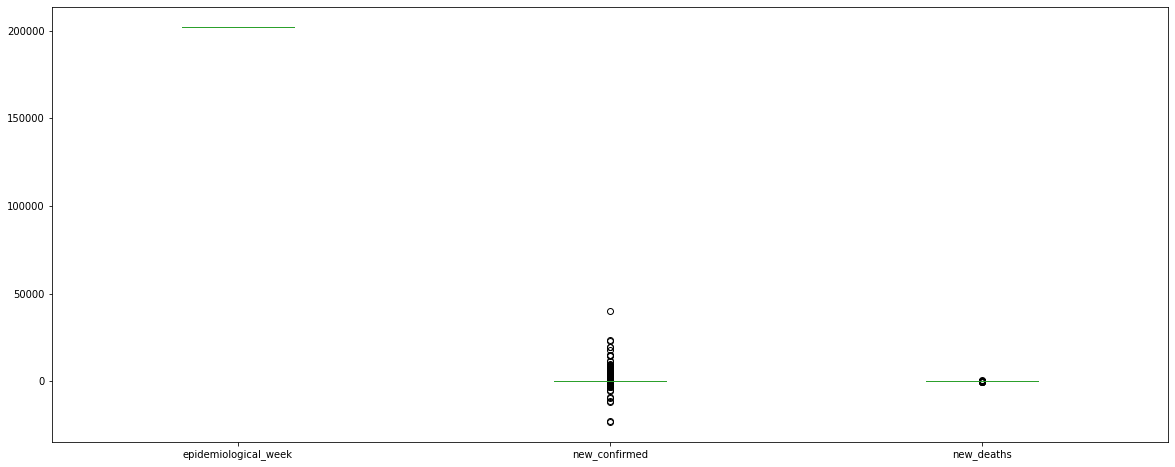

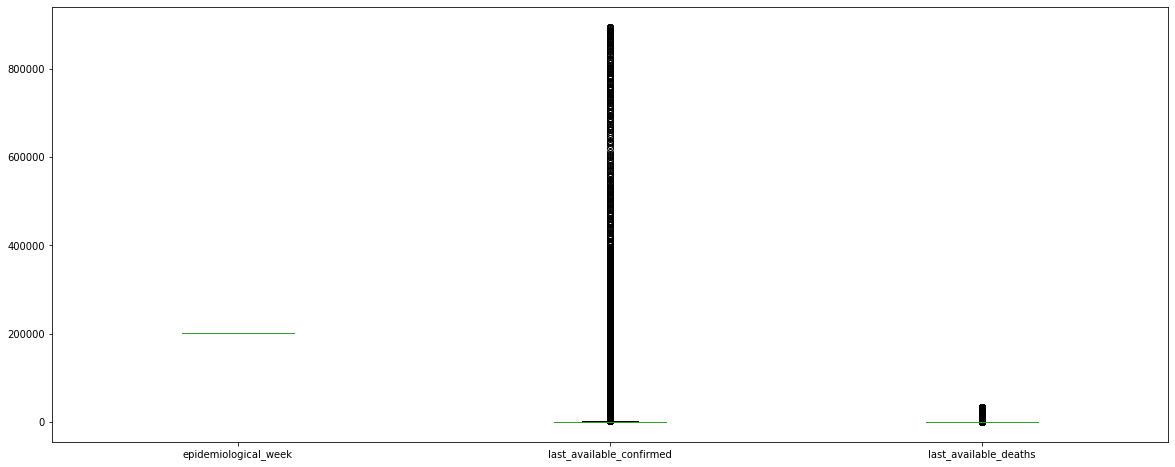

In [ ]:
# Visualizando boxplot do período total com outliers
df_filtered_new.plot.box(figsize=[20,8], showfliers=True)
df_filtered_acu.plot.box(figsize=[20,8], showfliers=True)

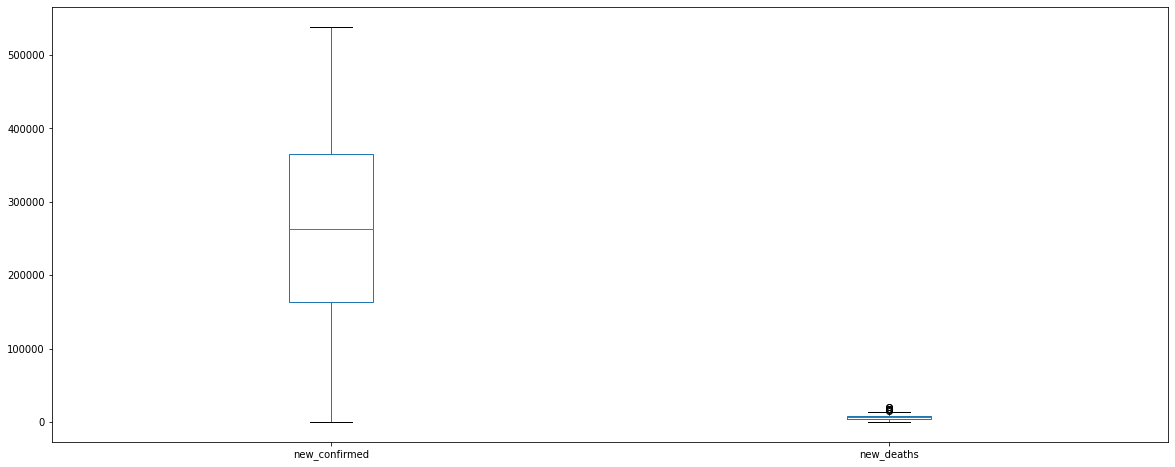

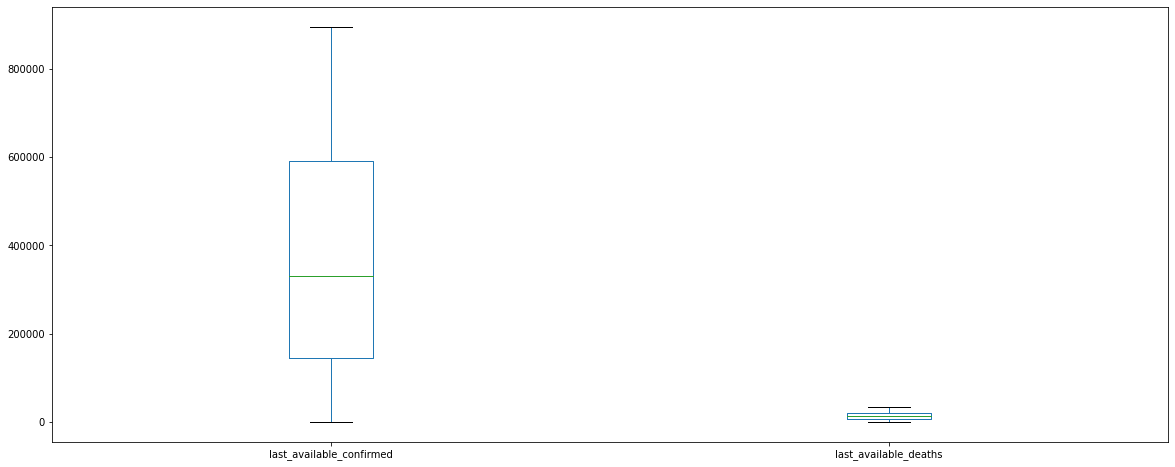

In [ ]:
# Agrupando por epidemiological_week para melhor visualização dos dados
df_filtered_new.groupby(['epidemiological_week']).sum().plot.box(figsize=[20,8], showfliers=True)
df_filtered_acu.groupby(['epidemiological_week']).max().plot.box(figsize=[20,8], showfliers=True)

##### **8.1.2.3 Violinplot**

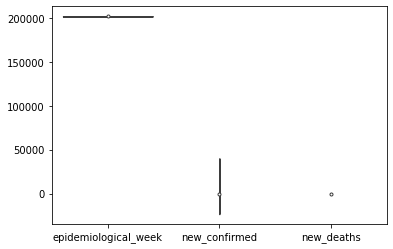

In [ ]:
# Visualizando violinplot do período total 
sns.violinplot(data=df_filtered_new)

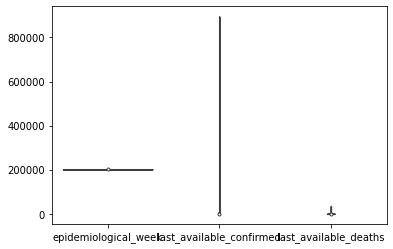

In [ ]:
sns.violinplot(data=df_filtered_acu)

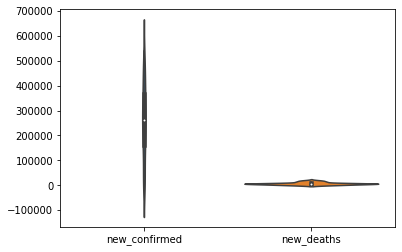

In [ ]:
# Agrupando por epidemiological_week para melhor visualização dos dados
sns.violinplot(data=df_filtered_new.groupby(['epidemiological_week']).sum())

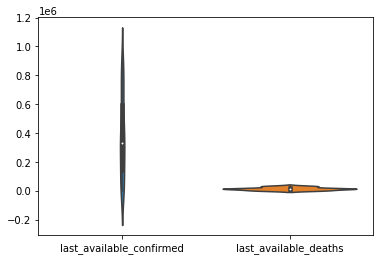

In [ ]:
sns.violinplot(data=df_filtered_acu.groupby(['epidemiological_week']).max())

**Conclusão:** Ao analisar os histogramas, boxplot e violinplot dos dados unificados, percebe-se que há uma grande variação de dados - de números muito baixos a números muito altos -, pois englobam todo o período da pandemia e todas as cidades do Brasil. Considerando isto, para mitigar tal variação, a base de dados foi agrupada por epidemiological_week, melhorando a visualização dos dados e possibilitando a identificação de picos e vales de casos e mortes e outliers.

#### **8.1.3 Mapa do Brasil: visualizando as somatórias das variáveis agrupadas das por estado**

Com o intuito de entender como a pandemia afetou cada estado de forma geral, foram criados mapas dos estados brasileiros com o somatório das variáveis do dataframe.

In [ ]:
# Baixando arquivo para plotar o mapa do Brasil
!gdown --id 1NLqVgj5Ax3m0mxm7k2E8UaqZ5-vop4gN
BRAZIL = gpd.read_file('bcim_2016_21_11_2018.gpkg', layer = 'lim_unidade_federacao_a')

Downloading...
From: https://drive.google.com/uc?id=1NLqVgj5Ax3m0mxm7k2E8UaqZ5-vop4gN
To: /content/bcim_2016_21_11_2018.gpkg
100% 373M/373M [00:02<00:00, 139MB/s]


In [ ]:
# Mudando o nome da coluna 'sigla' do arquivo 'BRAZIL' para 'state',
# com o intuito de facilitar a junção da série do COVID com os dados do 'BRAZIL'
BRAZIL.rename({'sigla': 'state'}, axis = 1, inplace = True)

In [ ]:
# Agrupando série do COVID por estado
df_state_agrupado = df_filtered_state.groupby(['state'])[['new_confirmed', 'new_deaths','new_confirmed_per_100k_inhabitants','new_deaths_per_100k_inhabitants']].sum().reset_index()

In [ ]:
# Criando nova variável 'death_rate'
df_state_agrupado.insert(5,'death_rate', df_state_agrupado['new_deaths'] / df_state_agrupado['new_confirmed'] , True)

In [ ]:
# Adicionando as variáveis do dataframe do COVID com os dados agrupados por estado no arquivo 'BRAZIL'
df_state_agrupado_mapa = BRAZIL.merge(df_state_agrupado, on ='state', how = 'left' )

Text(0.5, 0.98, 'Death rate por estado')

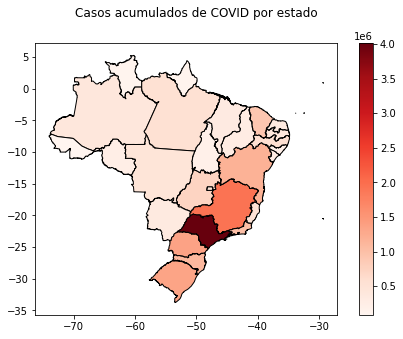

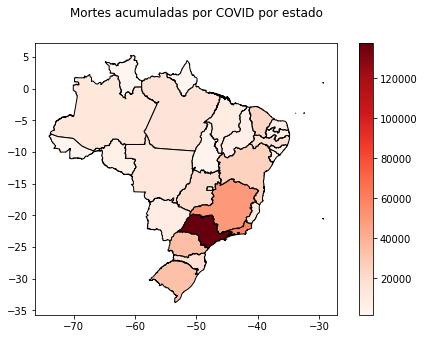

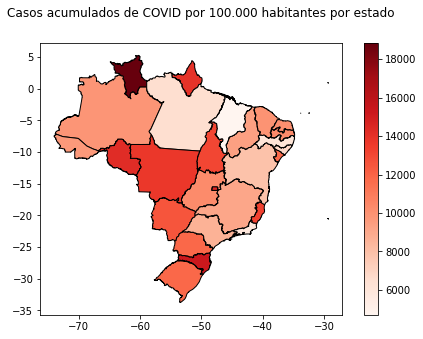

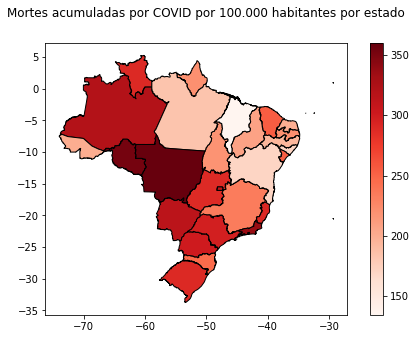

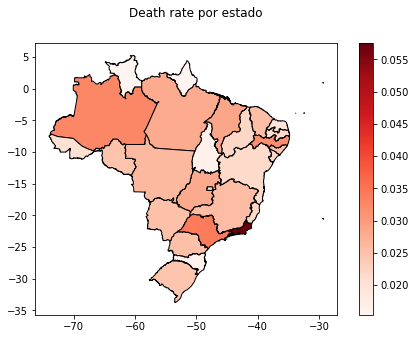

In [ ]:
# Mapa do Brasil visualizando casos e mortes pelo COVID
df_state_agrupado_mapa.plot(
    column = 'new_confirmed',
    cmap = 'Reds',
    figsize = (8,5),
    legend = True,
    edgecolor = 'black'
)
plt.suptitle('Casos acumulados de COVID por estado')

df_state_agrupado_mapa.plot(
    column = 'new_deaths',
    cmap = 'Reds',
    figsize = (8,5),
    legend = True,
    edgecolor = 'black'
)

# Mapa do Brasil visualizando casos e mortes por 100k habitantes pelo COVID
plt.suptitle('Mortes acumuladas por COVID por estado')

df_state_agrupado_mapa.plot(
    column = 'new_confirmed_per_100k_inhabitants',
    cmap = 'Reds',
    figsize = (8,5),
    legend = True,
    edgecolor = 'black'
)

plt.suptitle('Casos acumulados de COVID por 100.000 habitantes por estado')

df_state_agrupado_mapa.plot(
    column = 'new_deaths_per_100k_inhabitants',
    cmap = 'Reds',
    figsize = (8,5),
    legend = True,
    edgecolor = 'black'
)

plt.suptitle('Mortes acumuladas por COVID por 100.000 habitantes por estado')

# Mapa do Brasil visualizando death_rate pelo COVID
df_state_agrupado_mapa.plot(
    column = 'death_rate',
    cmap = 'Reds',
    figsize = (8,5),
    legend = True,
    edgecolor = 'black'
)

plt.suptitle('Death rate por estado')

**Conclusão:** Em número absolutos o Sudeste e Sul foram as regiões mais afetadas pelo COVID. Em relação aos estados, São Paulo e Rio de Janeiro foram os mais afetado.

Entretanto, quando compara-se os números de casos e mortes pelo o número de habitantes, a região Centro-Oeste e Norte foram os mais afetados pela pandemia. Sendo o Mato Grosso e Rondônia os estados mais afetados. Com base nisso, foi levantada a hipótese de que os números de novos casos e mortes por 100 mil habitantes estejam relacionados com o índice de desenvolvimento humano, visto que as regiões mais afetadas foram as com menor valores do IDH, diferentemente do números absolutos de novos casos e mortes. 

Ao observarmos o mapa do Death Rate percebemos que o Rio de Janeiro foi o estado mais afetado.


### **8.2 Analises das séries temporais**

#### **8.2.1 Mapa do Brasil: visualizando as variáveis ao longo do tempo agrupadas por estado**

Mapa que possibilita a visão da pandemia como um todo, visualizando como ela afetou os estados brasileiros ao longo do tempo. 

In [ ]:
# Agrupando por data ( frequencia = mês ) e estado
# Foi necessário separar o df em dois pois as variáveis tem datas diferentes ('date' e 'last_available_date')

df_state_agrupado_tm_m1 = df_filtered_state.groupby([pd.Grouper(key = 'last_available_date', freq='M'),'state'])[['state','last_available_confirmed', 'last_available_confirmed_per_100k_inhabitants','last_available_deaths','last_available_deaths_per_100k_inhabitants','last_available_death_rate']].sum().reset_index()

df_state_agrupado_tm_m2 = df_filtered_state.groupby([pd.Grouper(key = 'date', freq='M'),'state'])[['state','new_confirmed','new_deaths', 'new_confirmed_per_100k_inhabitants','new_deaths_per_100k_inhabitants']].sum().reset_index()

In [ ]:
# Baixando arquivo json necessário para fazer o mapa do Brasil
from urllib.request import urlopen
import json
with urlopen("https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson") as response:
    Brazil = json.load(response)

In [ ]:
# Definindo um ID que usaremos para juntar o dataframe do COVID e o arquivo Json
state_id_map = {}
for feature in Brazil ['features']:
 feature['id'] = feature['properties']['sigla']
 state_id_map[feature['properties']['sigla']] = feature['id']

In [ ]:
# Plotando o mapa dinâmico do Brasil
# O mapa não funciona no Colab, necessário rodar o código no computador para funcionar
#(O carregamento do mapa é pesado, é necessário esperar um pouco)
fig = px.choropleth(
                    df_state_agrupado_tm_m2, # casos agrupados por estados
                    geojson=Brazil,  #shape information
                    locations='state',     # definindo as regiões no mapa
                    #featureidkey ="properties.sigla", # defini qual campo será pego da base de dados do brazil para conectar com o data frame
                    color="new_deaths", #defining the color of the scale through the database
                    hover_name='state',  # define o texto interativo com o nome da região
                    hover_data=['new_confirmed'], # define o texto interativo com o numero de casos confirmasos e mortes
                    animation_frame=df_state_agrupado_tm_m2['date'].dt.strftime('%m-%Y'),   # define o animate_frame com as datas
                    title='Casos de COVID ao longo do tempo',    # define título
                    color_continuous_scale=px.colors.sequential.Magenta #  define a paleta de cores
                     )   
                   
fig.update_geos(fitbounds="locations" , visible = False) 
fig.show()

In [ ]:
# Plotando o mapa dinâmico do Brasil
fig = px.choropleth(
                    df_state_agrupado_tm_m2, # casos agrupados por estados
                    geojson=Brazil,  #shape information
                    locations='state',     # definindo as regiões no mapa
                    #featureidkey ="properties.sigla", # defini qual campo será pego da base de dados do brazil para conectar com o data frame
                    color="new_deaths", #defining the color of the scale through the database
                    hover_name='state',  # define o texto interativo com o nome da região
                    hover_data=['new_deaths'], # define o texto interativo com o numero de casos confirmasos e mortes
                    animation_frame=df_state_agrupado_tm_m2['date'].dt.strftime('%m-%Y'),   # define o animate_frame com as datas
                    title='Mortes por COVID ao longo do tempo',    # define título
                    color_continuous_scale=px.colors.sequential.Magenta #  define a paleta de cores
                     )   
                   
fig.update_geos(fitbounds="locations" , visible = False) 
fig.show()

#### **8.2.2 Gráficos de séries temporais**

Visualizando o comportamento da série ao longo do tempo. Vendo picos e tendências.

In [ ]:
# Transformação para séries temporais
df_state_agrupado_tm1 = df_filtered_state.groupby(['last_available_date', 'state'])[['last_available_confirmed', 'last_available_confirmed_per_100k_inhabitants','last_available_deaths', 'last_available_deaths_per_100k_inhabitants', 'last_available_death_rate']].sum().reset_index()
df_state_agrupado_tm2 = df_filtered_state.groupby(['date', 'state'])[['new_confirmed','new_deaths','new_confirmed_per_100k_inhabitants','new_deaths_per_100k_inhabitants']].sum().reset_index()

In [ ]:
# Séries temporais das variáveis agrupadas por estados

# Casos de COVID ao longo do tempo
fig = px.line(df_state_agrupado_tm2,
              x='date',
              y='new_confirmed',
              color='state',
              height=600,
              title='Casos Confirmados',
              color_discrete_sequence = px.colors.qualitative.Dark2 
              )
fig.show()

# Mortes por COVID ao longo do tempo
fig = px.line(df_state_agrupado_tm2,
              x="date",
              y='new_deaths',
              color='state',
              height=600,
              title='Mortes por COVID ao longo do tempo',
              color_discrete_sequence = px.colors.qualitative.Dark2)
fig.show()

# Casos de COVID por 100k habitantes ao longo do tempo
fig = px.line(df_state_agrupado_tm2,
              x='date',

              y='new_confirmed_per_100k_inhabitants',
              color='state',
              height=600,
              title='Casos de COVID por 100k habitantes ao longo do tempo',
              color_discrete_sequence = px.colors.qualitative.Dark2 )
fig.show()

# Mortes por 100k habitantes por COVID ao longo do tempo
fig = px.line(df_state_agrupado_tm2,
              x="date",
              y='new_deaths_per_100k_inhabitants',
              color='state',
              height=600,
              title='Mortes por 100k habitantes por COVID ao longo do tempo',
              color_discrete_sequence = px.colors.qualitative.Dark2)
fig.show()

# Death rate ao longo do tempo
fig = px.line(df_state_agrupado_tm1,
              x="last_available_date",
              y='last_available_death_rate',
              color='state',
              height=600,
              title='Death Rate ao longo do tempo',
              color_discrete_sequence = px.colors.qualitative.Dark2)
fig.show()

**Conclusão:** Consegue-se ver claramente as duas "ondas" da pandemia nos gráficos. A primeira inciando entre abril e maio de 2020 e a segunda em dezembro de 2020 e teve o pico de mortes em março. As séries apresentam vários picos, mostrando como a situação em relação ao vírus pode sair do controle rapidamente.

Ao observarmos o mapa do Death Rate percebemos que o houve uma curva de aprendizagem dos estados Brasileiros ao lidar com a pandemia, com isso resultando em em uma diminuição no número de mortes com o passar do tempo até se estabilizar. Há ainda alguns picos resultados, provavelmente, de quando o sistema de saúde colapsa e é necessário uma intervenção do Brasil para ajudar a região.

Aparentemente há uma sazonalidade nas séries de novos casos e novas mortes.

A curva de casos e mortes pela população do estado, na maoria dos casos, se comporta de maneira semelhante nos estados após um inicio do contágio do vírus. Gerando a hipótese que talvez tenha um padrão de comportamento do vírus indiferente do local infectato.

##### **8.2.2.1 Valores negativos de 'new_confirmed' e 'new_deaths'**

Nos gráficos de séries temporais evidenciam-se alguns valores negativos nas colunas 'new_confirmed' e 'new_deaths'. Acreditamos que se tratam de correções de dados passados.

Eles não impactam a avaliação da pandemia quando consideramos os somatórios os registros (variáveis como 'last_available_confirmed' e 'last_available_new_deaths). No entanto, no caso das séries temporais, foram geradas algumas distorções.

Esta seção tem como objetivo demonstrar que esses valores são raros e podem ser desconsiderados.

###### **8.2.2.1.1 'new_confirmed'**

In [ ]:
# Identificando os valores negativos
neg_new_confirmed = df_filtered_city[df_filtered_city['new_confirmed']<0]
neg_new_confirmed.count()

In [ ]:
# Verificando a porcentagem de valores negativos
(neg_new_confirmed['new_confirmed']).count() / (df_filtered_city['new_confirmed']).count() * 100

In [ ]:
# Distribuição dos valores negativos
neg_new_confirmed['new_confirmed'].hist(range = [min(neg_new_confirmed['new_confirmed']), -100])

**Conclusão:** A quantidade de registros negativos é insignificante frente ao volume de dados.

###### **8.2.2.1.2 'new_deaths'**

In [ ]:
# Identificando os valores negativos
neg_new_deaths = df_filtered_city[df_filtered_city['new_deaths']<0]
neg_new_deaths.count()

In [ ]:
# Verificando a porcentagem de valores negativos
(neg_new_deaths['new_deaths']).count() / (df_filtered_city['new_deaths']).count() * 100

In [ ]:
# Distribuição dos valores negativos
neg_new_deaths['new_deaths'].hist(range = [min(neg_new_deaths['new_deaths']), -10])

**Conclusão:** A quantidade de registros negativos é insignificante frente ao volume de dados.

#### **8.2.3 Tendências e sazonalidades**

Ao investigar a sazonalidade dos dados utilizamos dados dos estados e consolidados do Brasil. Por as séries apresentarem os mesmos resultados, e para deixar mais dinâmica a leitura do código, foi colocado somento os códigos referentes ao Brasil.

In [ ]:
# Os valores do dataframe foram agregados por dada, formando os números de casos do Brasil.
df_state_agrupado_tm3 = df_filtered_city.groupby('date')[['new_confirmed','new_deaths','new_confirmed_per_100k_inhabitants','new_deaths_per_100k_inhabitants']].sum()

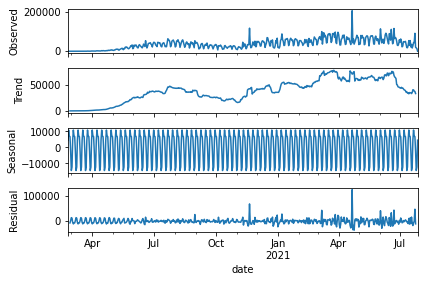

In [ ]:
# Investigando se há uma sazonalidade semanal na série de novos casos
analysis = df_state_agrupado_tm3[['new_confirmed']]

decompose_result_mult = seasonal_decompose(analysis, model="additive", freq=7)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

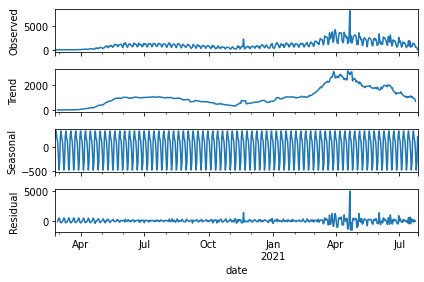

In [ ]:
# Investigando se ha'uma sazonalidade semanal na série de novas mortes
analysis = df_state_agrupado_tm3[['new_deaths']]

decompose_result_mult = seasonal_decompose(analysis, model="additive", freq=7)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

**Conclusão:** O número de novos casos e mortes de COVID no Brasil apresentam sazonalidade por semana, provalvelmente isso acontece pelo tempo de transmissão do vírus ou por causa de algo relacionado com a rotina do dia-a-dia das pessoas. Outra hipótese é que o sistema de cadastramentos dos dados de COVID seja afetado por uma rotina semanal.

### **8.3 Mapa de correlação**

Nesse tópico foi plotado dois heat maps com os índices de correlações das variavéis. No primeiro, os dados foram agregados por data para testar a correlação das variáveis de forma geral, contudo a variável 'estimated_population' ficou de fora. O segundo Heat Map foi feito agregando por município, para conseguirmoas analisar as correlações da variável 'estimated_population' e testar se há correlações diferentes dos dados agrupados por data.

##### **8.3.1 Testando a correlação das variáveis do Brasil agrupadas por data**

In [ ]:
df_filtered_var = df_filtered_state.groupby(['date'])[['new_confirmed','new_deaths','new_confirmed_per_100k_inhabitants','new_deaths_per_100k_inhabitants','last_available_confirmed', 'last_available_confirmed_per_100k_inhabitants','last_available_deaths', 'last_available_deaths_per_100k_inhabitants']].sum().reset_index()

In [ ]:
# Criando nova variável 'death_rate'
df_filtered_var.insert(9,'death_rate', df_filtered_var['new_deaths'] / df_filtered_var['new_confirmed'] , True)

In [ ]:
# Heat map do indíce de correlação de Perason entre variáveis

corr = df_filtered_var.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);
    

**Conclusão:** Os resultados obtidos foram de acordo com o previsto, sendo correlações lógicas entre as variáveis. 

Foi observado muitos coeficientes de correlação com valores altos, devido a varias variáveis serem o somatório de outras variáveis ou compostas pela mesma variável a qual está se correlacionado. Por causa disso no próximo mapa de correlação tiraremos algumas variáveis.

Foram observadas correlações como as das variáveis 'new_deaths' e 'new_confirmed', mostrando uma óbvia relação positiva entre os casos e os mortos do COVID.

##### **8.3.2 Testando a correlação das variáveis agrupadas por cidade**

In [ ]:
# Agrupando série do COVID por cidade
df_city_agrupado = df_filtered_city.groupby(['city'])[['new_confirmed', 'new_deaths','new_confirmed_per_100k_inhabitants','new_deaths_per_100k_inhabitants']].sum().reset_index()

In [ ]:
df_city_agrupado_pop = df_filtered_city.drop_duplicates(subset=['city']).reset_index()
df_city_agrupado_pop = df_city_agrupado_pop[['city', 'estimated_population']]

In [ ]:
# Junstando as duas séreis para adicionar a vairavel
df_city_agrupado = df_city_agrupado.merge(df_city_agrupado_pop, on ='city', how = 'left' )

In [ ]:
# Criando nova variável 'death_rate'
df_city_agrupado.insert(5,'death_rate', df_city_agrupado['new_deaths'] / df_city_agrupado['new_confirmed'] , True)

In [ ]:
# Heat map do índice de correlação de Perason entre variáveis

corr2 = df_city_agrupado.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr2, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

**Conclusão:**

 Novamente é confirmada a relação positivas entre casos e mortes por COVID. A população das cidades também encontrou um alto valor de correlação em relação aos novos casos e mortes de COVID, mas não a taxa de mortalidade. 

Isso ocorre porque o número absoluto de casos é proporcionalmente maior em cidades com maior população.

## **9 Teste de hipótese: relação entre a taxa de mortalidade e o IDHM**

**Hipótese:** as cidades com maiores índice de desenvolvimento humano municipal (IDHM) promoveram melhores políticas de controle da pandemia, e apresentaram menores taxas de mortalidade.

### **9.1 Importando os dados auxiliares**

In [ ]:
# Baixando as bases de dados auxiliares do Google Drive
!gdown --id 1UnTCIoTaVs92bmF_rzpzoHOXesoXNHet
!gdown --id 1PrDLQi-b5k_wUmch3qLSomF3gDzIZcNB

In [ ]:
# Lendo a base de dados auxiliar sobre IDHM
df_idh_2010 = pd.read_csv('idh_2010.csv', delimiter=';', decimal=',')

# Lendo a base de dados auxiliar sobre divisão territorial brasileira (DTB)
df_dtb = pd.read_csv('dtb.csv', delimiter=';')

### **9.2 Criando as variáveis de interesse**

In [ ]:
# Visualizando a base de dados sobre IDHM
display(df_idh_2010)

In [ ]:
# Selecionando as variáveis de interesse sobre IDHM
df_idh_2010 = pd.DataFrame({
    'Territorialidade': df_idh_2010['Territorialidade'],
    'IDHM': df_idh_2010['IDHM'],
    'IDHM Renda': df_idh_2010['IDHM Renda'],
    'IDHM Educação': df_idh_2010['IDHM Educação'],
    'IDHM Longevidade': df_idh_2010['IDHM Longevidade']})

# Visualizando os dados selecionados sobre IDHM
display(df_idh_2010)

In [ ]:
# Visualizando a base de dados sobre DTB
display(df_dtb)

In [ ]:
# Criando a variável 'Territorialidade' na base de dados sobre DTB,
# para torná-la compatível com a base de dados sobre IDHM

estados = pd.DataFrame({
    'Nome_UF':['Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará', 'Distrito Federal', 'Espírito Santo', 'Goiás',
              'Maranhão', 'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais', 'Paraná', 'Paraíba', 'Pará', 'Pernambuco',
              'Piauí', 'Rio Grande do Norte', 'Rio Grande do Sul', 'Rio de Janeiro', 'Rondônia', 'Roraima', 'Santa Catarina',
              'Sergipe', 'São Paulo', 'Tocantins'],
    'Sigla':['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO',
             'MA', 'MT', 'MS', 'MG', 'PR', 'PB', 'PA', 'PE',
             'PI', 'RN', 'RS', 'RJ', 'RO', 'RR', 'SC',
             'SE', 'SP', 'TO']})
df_dtb = pd.merge(df_dtb, estados, how = 'outer')
df_dtb['Territorialidade'] = df_dtb['Nome_Município'] + ' (' + df_dtb['Sigla'] + ')'

In [ ]:
# Selecionando as variáveis de interesse sobre DTB
df_dtb = pd.DataFrame({
    'Código Município Completo': df_dtb['Código Município Completo'],
    'Territorialidade': df_dtb['Territorialidade']})

# Visualizando os dados selecionados sobre DTB    
display(df_dtb)

### **9.3 Testando a consistência dos novos dados**

#### **9.3.1 Identificando os valores nulos**

In [ ]:
# Contando os valores nulos por colunas
df_dtb.isnull().sum()

In [ ]:
# Contando os valores nulos por colunas
df_idh_2010.isnull().sum()

**Conclusão:** Dados não apresentam valores nulos.

#### **9.3.2 Sanity Check**

**Hipótese**: IDHM está sendo calculado errado. 


In [ ]:
df_idh_2010_test = df_idh_2010

In [ ]:
df_idh_2010_test.insert(5,"test_IDHM",(round(df_idh_2010['IDHM'],3)==round((df_idh_2010['IDHM Renda'] * df_idh_2010['IDHM Educação'] * df_idh_2010['IDHM Longevidade'])**(1/3),3)),True)

In [ ]:
df_idh_2010_test["test_IDHM"].value_counts()

**Conclusão:** A hipótese é falsa e os dados se encontram consistentes.

### **9.4 Unificando as bases de dados auxiliares**

In [ ]:
# Unindo os dados sobre IDHM e DTB
df_auxiliar = pd.merge(df_dtb, df_idh_2010, how = 'outer')
display(df_auxiliar)

In [ ]:
# Somando os valores nulos por colunas
df_auxiliar.isnull().sum()

In [ ]:
# Visualizando as linhas com valores nulos
nulos = df_auxiliar[(df_auxiliar['Código Município Completo'].isnull() | df_auxiliar['IDHM'].isnull())]
display(nulos)

In [ ]:
# Agrupando as linhas com valores nulos por município
nulos.groupby('Territorialidade').count()

In [ ]:
# Corrigindo erros de digitação
df_idh_2010['Territorialidade'] = df_idh_2010['Territorialidade'].replace(['Abreu E Lima (PE)',
                                                                           "Aparecida D'Oeste (SP)",
                                                                           'Araças (BA)',
                                                                           'Atilio Vivacqua (ES)',
                                                                           'Biritiba-Mirim (SP)',
                                                                           "Dias D'Ávila (BA)",
                                                                           'Dona Eusébia (MG)',
                                                                           'Embu (SP)',
                                                                           'Ererê (CE)',
                                                                           "Estrela D'Oeste (SP)",
                                                                           'Florínia (SP)',
                                                                           'Grão Pará (SC)',
                                                                           "Guarani D'Oeste (SP)",
                                                                           "Herval D'Oeste (SC)",
                                                                           'Iguaraci (PE)',
                                                                           'Itapagé (CE)',
                                                                           "Itapejara D'Oeste (PR)",
                                                                           "Itaporanga D'Ajuda (SE)",
                                                                           'Itaóca (SP)',
                                                                           "Lagoa D'Anta (RN)",
                                                                           'Lauro Muller (SC)',
                                                                           "Mirassol D'Oeste (MT)",
                                                                           'Muquém de São Francisco (BA)',
                                                                           "Mãe D'Água (PB)",
                                                                           "Olho D'Água (PB)",
                                                                           "Olho D'Água Grande (AL)",
                                                                           "Olho D'Água das Cunhãs (MA)",
                                                                           "Olho D'Água das Flores (AL)",
                                                                           "Olho D'Água do Casado (AL)",
                                                                           "Olho-D'Água do Borges (RN)",
                                                                           "Olhos-D'Água (MG)",
                                                                           "Palmeira D'Oeste (SP)",
                                                                           'Passa E Fica (RN)',
                                                                           "Passa-Vinte (MG)",
                                                                           'Pedro Ii (PI)',
                                                                           "Pingo-D'Água (MG)",
                                                                           'Pio Ix (PI)',
                                                                           'Pio Xii (MA)',
                                                                           'Pontes E Lacerda (MT)',
                                                                           'Poxoréo (MT)',
                                                                           "Pérola D'Oeste (PR)",
                                                                           'Quixabá (PB)',
                                                                           'Restinga Seca (RS)',
                                                                           "Santa Bárbara D'Oeste (SP)",
                                                                           "Santa Clara D'Oeste (SP)",
                                                                           'Santa Isabel do Pará (PA)',
                                                                           "Santa Rita D'Oeste (SP)",
                                                                           'Santa Teresinha (BA)',
                                                                           'São Cristovão do Sul (SC)',
                                                                           "São Jorge D'Oeste (PR)",
                                                                           "São João D'Aliança (GO)",
                                                                           'São João Del Rei (MG)',
                                                                           "São João do Pau D'Alho (SP)",
                                                                           'São Luís do Paraitinga (SP)',
                                                                           'São Luíz do Norte (GO)',
                                                                           'São Vicente Ferrer (PE)',
                                                                           "Sítio D'Abadia (GO)",
                                                                           "Tanque D'Arca (AL)",
                                                                           'Vespasiano Correa (RS)',
                                                                           'Westfalia (RS)',
                                                                           'Xangri-Lá (RS)'],
                                                                          ['Abreu e Lima (PE)',
                                                                           "Aparecida d'Oeste (SP)",
                                                                           'Araçás (BA)',
                                                                           'Atílio Vivácqua (ES)',
                                                                           'Biritiba Mirim (SP)',
                                                                           "Dias d'Ávila (BA)",
                                                                           'Dona Euzébia (MG)',
                                                                           'Embu das Artes (SP)',
                                                                           'Ereré (CE)',
                                                                           "Estrela d'Oeste (SP)",
                                                                           'Florínea (SP)',
                                                                           'Grão-Pará (SC)',
                                                                           "Guarani d'Oeste (SP)",
                                                                           "Herval d'Oeste (SC)",
                                                                           'Iguaracy (PE)',
                                                                           'Itapajé (CE)',
                                                                           "Itapejara d'Oeste (PR)",
                                                                           "Itaporanga d'Ajuda (SE)",
                                                                           'Itaoca (SP)',
                                                                           "Lagoa d'Anta (RN)",
                                                                           'Lauro Müller (SC)',
                                                                           "Mirassol d'Oeste (MT)",
                                                                           'Muquém do São Francisco (BA)',
                                                                           "Mãe d'Água (PB)",
                                                                           "Olho d'Água (PB)",
                                                                           "Olho d'Água Grande (AL)",
                                                                           "Olho d'Água das Cunhãs (MA)",
                                                                           "Olho d'Água das Flores (AL)",
                                                                           "Olho d'Água do Casado (AL)",
                                                                           "Olho d'Água do Borges (RN)",
                                                                           "Olhos d'Água (MG)",
                                                                           "Palmeira d'Oeste (SP)",
                                                                           'Passa e Fica (RN)',
                                                                           'Passa Vinte (MG)',
                                                                           'Pedro II (PI)',
                                                                           "Pingo d'Água (MG)",
                                                                           'Pio IX (PI)',
                                                                           'Pio XII (MA)',
                                                                           'Pontes e Lacerda (MT)',
                                                                           'Poxoréu (MT)',
                                                                           "Pérola d'Oeste (PR)",
                                                                           'Quixaba (PB)',
                                                                           'Restinga Sêca (RS)',
                                                                           "Santa Bárbara d'Oeste (SP)",
                                                                           "Santa Clara d'Oeste (SP)",
                                                                           'Santa Izabel do Pará (PA)',
                                                                           "Santa Rita d'Oeste (SP)",
                                                                           'Santa Terezinha (BA)',
                                                                           'São Cristóvão do Sul (SC)',
                                                                           "São Jorge d'Oeste (PR)",
                                                                           "São João d'Aliança (GO)",
                                                                           "São João del-Rei (MG)",
                                                                           "São João do Pau d'Alho (SP)",
                                                                           'São Luiz do Paraitinga (SP)',
                                                                           'São Luiz do Norte (GO)',
                                                                           'São Vicente Férrer (PE)',
                                                                           "Sítio d'Abadia (GO)",
                                                                           "Tanque d'Arca (AL)",
                                                                           'Vespasiano Corrêa (RS)',
                                                                           'Westfália (RS)',
                                                                           'Xangri-lá (RS)'])
df_dtb['Territorialidade'] = df_dtb['Territorialidade'].replace(['Amparo do São Francisco (SE)', 
                                                                 'Brazópolis (MG)',
                                                                 'Eldorado do Carajás (PA)',
                                                                 'Iuiu (BA)',
                                                                 "Olhos-d'Água (MG)",
                                                                 "Pingo-d'Água (MG)",
                                                                 'São João del Rei (MG)',
                                                                 'São Tomé das Letras (MG)'],
                                                                ['Amparo de São Francisco (SE)',
                                                                  'Brasópolis (MG)',
                                                                 'Eldorado dos Carajás (PA)',
                                                                 'Iuiú (BA)',
                                                                 "Olhos d'Água (MG)",
                                                                 "Pingo d'Água (MG)",
                                                                 "São João del-Rei (MG)",
                                                                 'São Thomé das Letras (MG)'])

In [ ]:
# Sobrescrevendo os dataframes antigos
df_auxiliar = pd.merge(df_dtb, df_idh_2010, how = 'outer')


In [ ]:
#Vizualizando os dados
df_auxiliar

In [ ]:
nulos = df_auxiliar[(df_auxiliar['Código Município Completo'].isnull() | df_auxiliar['IDHM'].isnull())]

# Avaliando o resultado da correção, contando os nulos
nulos.groupby('Territorialidade').count()

**Conclusão:** As bases de dados sobre IDHM e DTB foram compatibilizadas.Os nulos encontratos são resultados das restante apenas 15 municípios sem correspondência em ambas as bases de dados unidas no tópico 9.3 e serão descardados nas analises.

### **9.5 Unindo as bases de dados principal e auxiliar**

In [ ]:
# Renomeando a variável 'Código Município Completo' para garantir compatibilidade entre as bases
df_auxiliar = df_auxiliar.rename(columns = {'Código Município Completo': 'city_ibge_code'})

# Unindo as bases de dados principal e auxiliar
df_full = pd.merge(df_filtered_city, df_auxiliar, how = 'outer')

display(df_full)

In [ ]:
# Somando os valores nulos por coluna
df_full.isnull().sum()

In [ ]:
# Identificando os municípios não previstos na base de dados principal
(df_full[df_full['city'].isnull()]).groupby('Territorialidade').count()

In [ ]:
# Identificando os municípios sem valores correspondentes de IDHM
df_full[df_full['IDHM'].isnull()].groupby('Territorialidade').count()

In [ ]:
# Tratando os valores nulos
df_full = df_full.dropna()
df_full.isnull().sum()

In [ ]:
# Validando os tipos de variáveis
df_full.info()

### **9.6 Teste de hipótese**

#### **9.6.1 Mapa de correlação**

In [ ]:
df_full_idhm = df_full.drop_duplicates(subset=['city']).reset_index()
df_full_idhm = df_full_idhm[['city', 'IDHM','IDHM Renda','IDHM Educação','IDHM Longevidade']]

In [ ]:
# Unindo as duas séries para adicionar a variável
df_full_city = df_full_idhm.merge(df_city_agrupado, on ='city', how = 'inner')

In [ ]:
# Heat map do indíce de correlação de Perason entre variáveis
corr3 = df_full_city.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr3, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

  #### **9.6.2 Gráfico de dispersão**

In [ ]:
# Gráficos de dispersão dos resultados
plt.scatter(df_full_city['IDHM'], df_full_city['death_rate'])

In [ ]:
plt.scatter(df_full_city['IDHM Renda'], df_full_city['death_rate'])

In [ ]:
plt.scatter(df_full_city['IDHM Educação'], df_full_city['death_rate'])

In [ ]:
plt.scatter(df_full_city['IDHM Longevidade'], df_full_city['death_rate'])

**Conclusão:** Tanto o teste de correlação quanto os gráficos de dispersão não evidenciam relações entre as variáveis de interesse.

  #### **9.6.3 Regressões**

Nesse tópico foi feito uma regressão linear para testar se a variável 'IDHM' conseguem explicar a variável 'death_rate'.

In [ ]:
# Importando as bases necessárias
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

In [ ]:
 X = df_full_city[['IDHM']]
 Y = df_full_city['death_rate']

In [ ]:
# Escolhendo o modelo
model = linear_model.LinearRegression()

In [ ]:
# aaplicando o modelo e salvando predições
model.fit(X, Y)
Y_pred = model.predict(X)

In [ ]:
# Verificando estatísticas 
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y,Y_pred))


In [ ]:
# Estatísticas mais aprofundadas
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2).fit()
print(est.summary())

**Conclusão:** O  valor do r² da regressão  indica que o 'IDHM' não consegue explicar a variável 'death_rate' usando o modelo de regressão linear . O valor-p da variável 'IDHM' ainda nos diz que ela não é significativa. Assim, não corroborando com a hipótese de que o IDHM influencia noa taxa de morte pelo COVID dos municípios. Esses resultados já ream esperados tendo em vista os valores obtitidos nas correlações.